# **ELO RECOMMENDATION**

In [1]:
import os 
print(os.getcwd())
%cd ..
os.chdir('/kaggle/input')

/kaggle/working
/kaggle


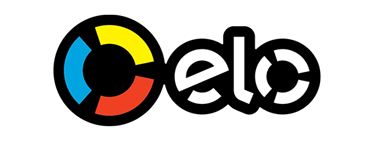

In [2]:
from IPython.display import Image
Image("eloimage/elo-image.png")

## **So what is elo and what is it's objective in this competition?**

#### *Elo, one of the largest payment brands in Brazil, has built partnerships with merchants in order to offer promotions or discounts to cardholders. But do these promotions work for either the consumer or the merchant? Do customers enjoy their experience? Do merchants see repeat business? Personalization is key.*
#### *Elo has built machine learning models to understand the most important aspects and preferences in their customers’ lifecycle, from food to shopping. But so far none of them is specifically tailored for an individual or profile.*

#### The Objective: *In this competition, Kagglers will develop algorithms to identify and serve the most relevant opportunities to individuals, by uncovering signal in customer loyalty. Your input will improve customers’ lives and help Elo reduce unwanted campaigns, to create the right experience for customers.*

> ##### Let's start with moving all our data into the working directory as our input directory is a **'read-only'** directory.

In [3]:
import shutil 
try:
    shutil.move("/kaggle/input","/kaggle/working")
except:
    print('Data files have been moved into the working directory successfully')

Data files have been moved into the working directory successfully


In [4]:
%cd /kaggle/working/input/elo-merchant-category-recommendation
%ls

/kaggle/working/input/elo-merchant-category-recommendation
Data_Dictionary.xlsx         new_merchant_transactions.csv  train.csv
historical_transactions.csv  sample_submission.csv
merchants.csv                test.csv


> ### The files available to us are:


1. The train.csv and test.csv files which contain the card_ids that we'll be using for training and prediction.

2. The historical_transactions.csv and new_merchant_transactions.csv files which contain information about each card's transactions. historical_transactions.csv contains up to 3 months' worth of transactions for every card at any of the provided merchant_ids. new_merchant_transactions.csv contains the transactions at new merchants (merchant_ids that this particular card_id has not yet visited) over a period of two months.

3. merchants.csv contains aggregate information for each merchant_id represented in the data set.


> ### File discriptions:

1. train.csv - the training set
2. test.csv - the test set
3. sample_submission.csv - a sample submission file in the correct format - contains all card_ids you are expected to predict for.
4. historical_transactions.csv - up to 3 months' worth of historical transactions for each card_id
5. merchants.csv - additional information about all merchants / merchant_ids in the dataset.
6. new_merchant_transactions.csv - two months' worth of data for each card_id containing ALL purchases that card_id made at merchant_ids that were not visited in the historical data.

> ### What is our target label or dependent variable?

*We are predicting a loyalty score for each card_id represented in test.csv and sample_submission.csv.*



## The features available to us are:
#### In train.csv and test.csv files we have:

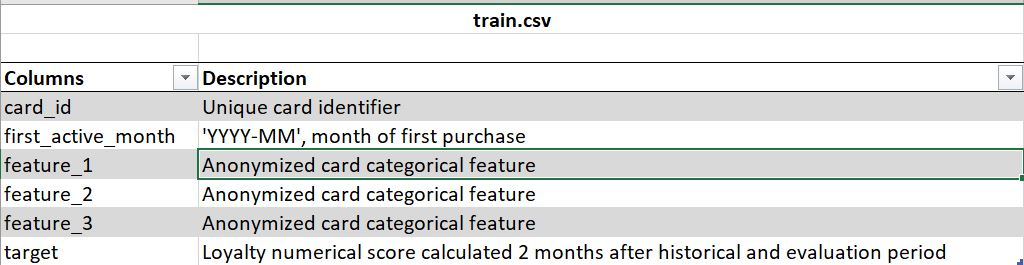

In [5]:
from IPython.display import Image
Image("/kaggle/working/input/features/train_features.JPG")

#### In the merchants.csv file we have:

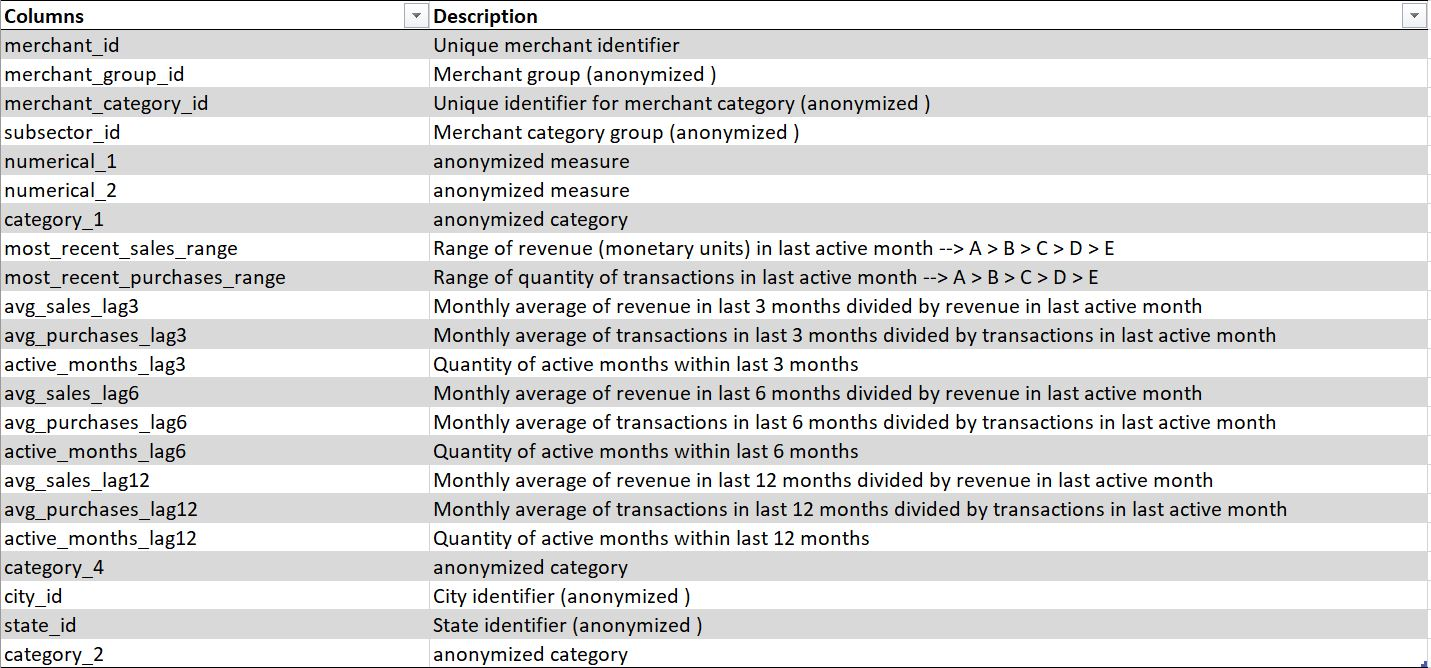

In [6]:
from IPython.display import Image
Image("/kaggle/working/input/features/merchant.JPG")

#### In the historical_transactions.csv and new_merchant_transactions.csv we have:

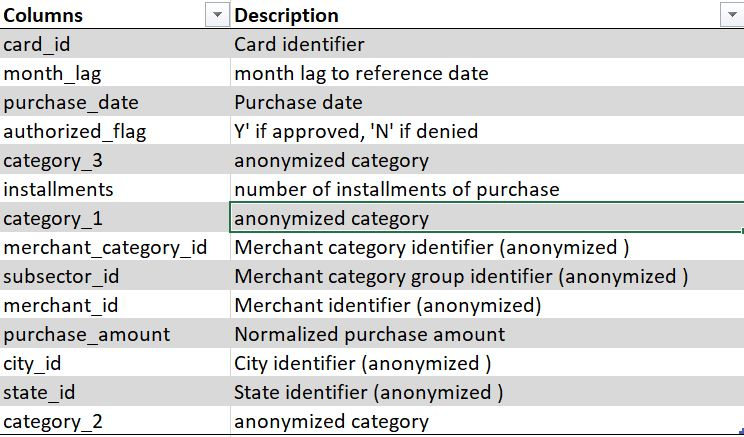

In [7]:
from IPython.display import Image
Image("/kaggle/working/input/features/history.JPG")

## References:
1. You're Going to Want More Categories [LB 3.737] by Peter Hurford
2. EloDA with Feature Engineering and Stacking by Bojan Tunguz
3. A Closer Look at Date Variables by Robin Denz
4. LGB + FE (LB 3.707) by Konrad Banachewicz
5. My first kernel (3.699) by Chau Ngoc Huynh
6. Elo World by fabien daniel
7. Simple Exploration Notebook- Elo by SRK

## Notebook Content:
1. Loading data
2. Exploratory Data Analysis
3. Feature Engineeiring
4. Model building and training
5. Feature Importance
6. Fine tuning and model selection
7. Submission

In [8]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

# Part - 1 : Loading Data  

### *The datasets eat a lot of memory so it is advised to load and save memory as much as possible. For this reason, I used Fabien daniel's function for memory usage reduction.*

In [9]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [10]:
train = reduce_mem_usage(pd.read_csv("train.csv", parse_dates=["first_active_month"]))
test = reduce_mem_usage(pd.read_csv("test.csv", parse_dates=["first_active_month"]))
print("Number of rows and columns in train set : ",train.shape)
print("Number of rows and columns in test set : ",test.shape)

Mem. usage decreased to  4.04 Mb (56.2% reduction)
Mem. usage decreased to  2.24 Mb (52.5% reduction)
Number of rows and columns in train set :  (201917, 6)
Number of rows and columns in test set :  (123623, 5)


## Exploring the training data:

In [11]:
print(train.head(5))
print(train.info())
train.describe()

  first_active_month          card_id  feature_1  feature_2  feature_3  \
0         2017-06-01  C_ID_92a2005557          5          2          1   
1         2017-01-01  C_ID_3d0044924f          4          1          0   
2         2016-08-01  C_ID_d639edf6cd          2          2          0   
3         2017-09-01  C_ID_186d6a6901          4          3          0   
4         2017-11-01  C_ID_cdbd2c0db2          1          3          0   

     target  
0 -0.820312  
1  0.392822  
2  0.687988  
3  0.142456  
4 -0.159790  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null datetime64[ns]
card_id               201917 non-null object
feature_1             201917 non-null int8
feature_2             201917 non-null int8
feature_3             201917 non-null int8
target                201917 non-null float16
dtypes: datetime64[ns](1), float16(1), int8(3), object(1)
memory usage: 4.0+ MB
None


,feature_1,feature_2,feature_3,target
count,201917.000000,201917.000000,201917.000000,201917.000000
mean,3.105311,1.745410,0.565569,NaN
std,1.186160,0.751362,0.495683,0.000000
min,1.000000,1.000000,0.000000,-33.218750
25%,2.000000,1.000000,0.000000,-0.883301
50%,3.000000,2.000000,1.000000,-0.023438
75%,4.000000,2.000000,1.000000,0.765625
max,5.000000,3.000000,1.000000,17.968750


### Observations:
1. No null or missing values in our training data, hence not much cleaning is required.
2. Features such as feature_1,feature_2 and feature_3 are anonymized and need to be explored deeper.
3. Th target-loyalty score has a negative mean, with 50 % and less data having negative values.

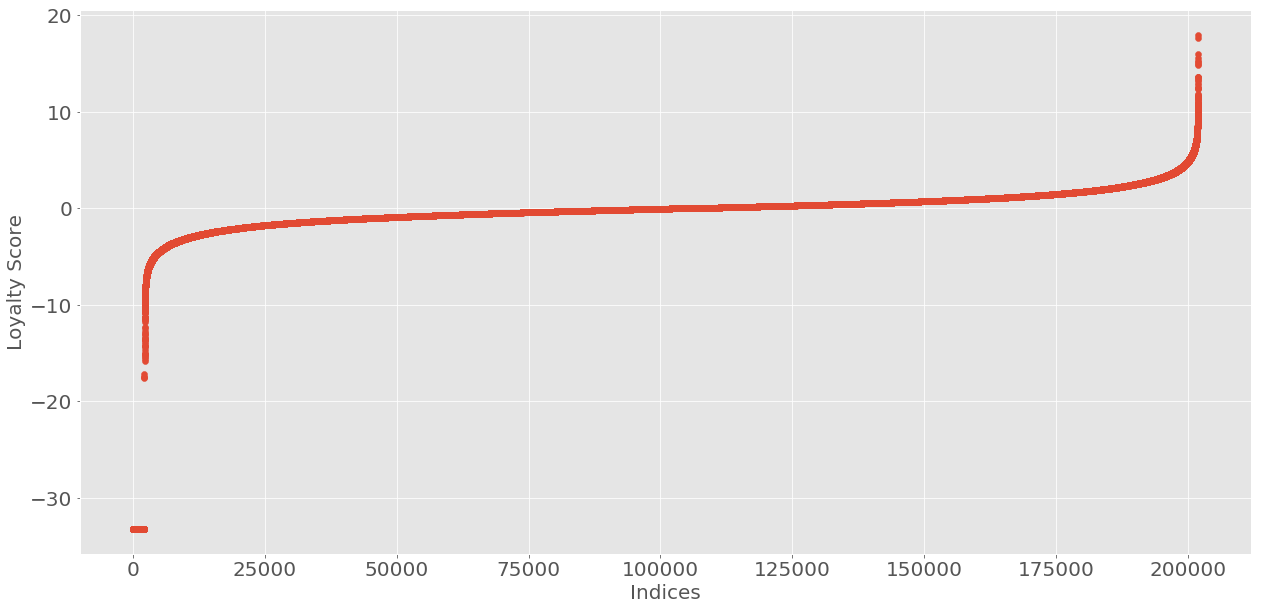

In [12]:
from matplotlib import style
style.use('ggplot')
plt.figure(figsize=(21,10))
plt.scatter(range(train.shape[0]),sorted(train.target.values))
plt.xlabel('Indices',fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('Loyalty Score',fontsize=20)
plt.yticks(fontsize=20)
plt.show();

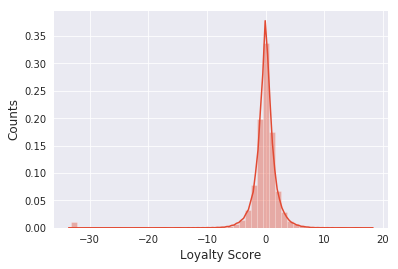

In [13]:
sns.set_style('darkgrid')
sns.distplot(train['target'],rug=False,kde=True,hist=True)
plt.ylabel('Counts')
plt.xlabel('Loyalty Score')
plt.show();

### Observations:
1. The Loyalty score distribution is almost normally distributed with some negative values.
2. There are certainly a few outliers on the negative side.

### Exploring is there is any change in the distribution of first active month in the train and test datasets.

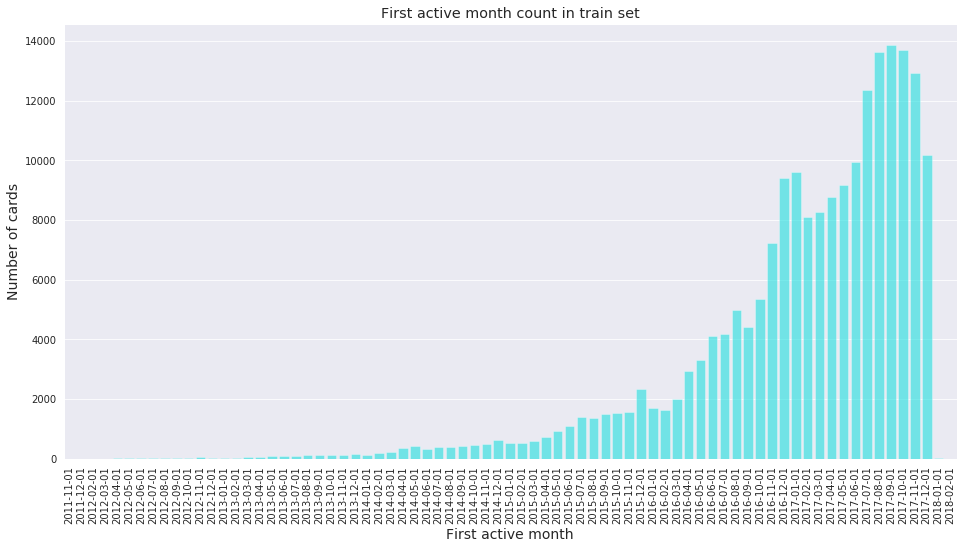

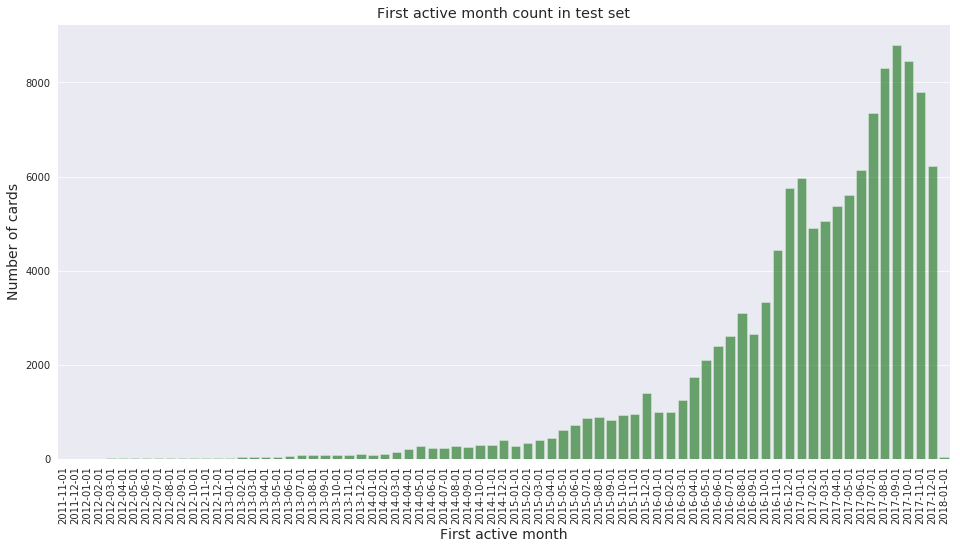

In [14]:
cnt_srs= train['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(16,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.6, color='cyan')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=14)
plt.ylabel('Number of cards', fontsize=14)
plt.title("First active month count in train set")
plt.show()

cnt_srs = test['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(16,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.6, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=14)
plt.ylabel('Number of cards', fontsize=14)
plt.title("First active month count in test set")
plt.show()

We see there is hardly any difference in the distributions of first active month for training and testing data.

In [15]:
print(plt.style.available)

['_classic_test', 'seaborn-deep', 'seaborn-paper', 'fast', 'ggplot', 'seaborn-bright', 'Solarize_Light2', 'seaborn-white', 'grayscale', 'seaborn', 'seaborn-dark', 'tableau-colorblind10', 'seaborn-pastel', 'dark_background', 'seaborn-muted', 'seaborn-notebook', 'seaborn-ticks', 'seaborn-talk', 'seaborn-poster', 'bmh', 'seaborn-whitegrid', 'fivethirtyeight', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-darkgrid', 'classic']


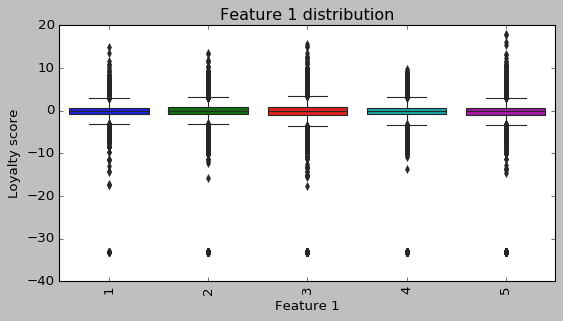

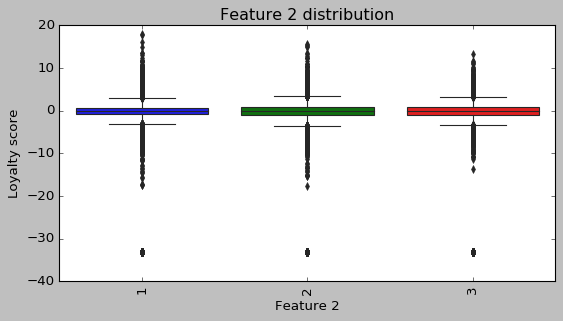

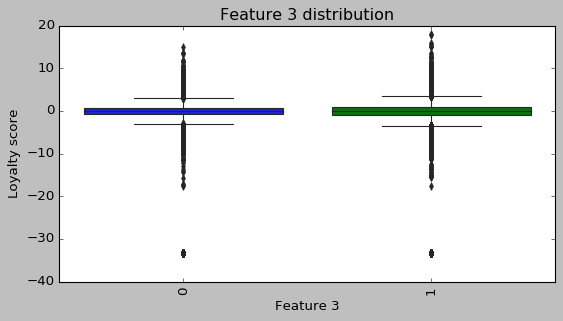

In [16]:

# feature 1
#style.use('tableau-colorblind10')
style.use('classic')
plt.figure(figsize=(8,4))
sns.boxplot(x="feature_1", y='target', data=train)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 1 distribution")
plt.show()

# feature 2
#style.use('fast')

plt.figure(figsize=(8,4))
sns.boxplot(x="feature_2", y='target', data=train)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 2', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 2 distribution")
plt.show()

# feature 3

plt.figure(figsize=(8,4))
sns.boxplot(x="feature_3", y='target', data=train)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 3', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 3 distribution")
plt.show()

Each feature here has almost the same distribution , close to gaussian, but with varying categories or buckets.

In [17]:
train[['feature_1','feature_2','feature_3']].head(5)

,feature_1,feature_2,feature_3
0,5,2,1
1,4,1,0
2,2,2,0
3,4,3,0
4,1,3,0


In [18]:
train['target'].head(5)

0   -0.820312
1    0.392822
2    0.687988
3    0.142456
4   -0.159790
Name: target, dtype: float16

In [19]:
for i in ['feature_1','feature_2','feature_3']:
    print('The number of buckets in '+str(i)+' is',train[i].nunique())
    print('The buckets are :'+'\n',train[i].value_counts())

The number of buckets in feature_1 is 5
The buckets are :
 3    73573
2    55797
5    40625
4    19885
1    12037
Name: feature_1, dtype: int64
The number of buckets in feature_2 is 3
The buckets are :
 1    89242
2    74839
3    37836
Name: feature_2, dtype: int64
The number of buckets in feature_3 is 2
The buckets are :
 1    114198
0     87719
Name: feature_3, dtype: int64


## Now reading in the historical and new transactions data

In [20]:
new_transactions = reduce_mem_usage(pd.read_csv('new_merchant_transactions.csv',
                               parse_dates=['purchase_date']))

historical_transactions =reduce_mem_usage(pd.read_csv('historical_transactions.csv',
                                      parse_dates=['purchase_date']))

Mem. usage decreased to 114.20 Mb (45.5% reduction)
Mem. usage decreased to 1749.11 Mb (43.7% reduction)


In [21]:
print(historical_transactions.columns)
print(historical_transactions.info())
historical_transactions.describe()

Index(['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'purchase_date', 'category_2', 'state_id',
       'subsector_id'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
authorized_flag         object
card_id                 object
city_id                 int16
category_1              object
installments            int16
category_3              object
merchant_category_id    int16
merchant_id             object
month_lag               int8
purchase_amount         float32
purchase_date           datetime64[ns]
category_2              float16
state_id                int8
subsector_id            int8
dtypes: datetime64[ns](1), float16(1), float32(1), int16(3), int8(3), object(5)
memory usage: 1.7+ GB
None


,city_id,installments,merchant_category_id,month_lag,purchase_amount,category_2,state_id,subsector_id
count,2.911236e+07,2.911236e+07,2.911236e+07,2.911236e+07,2.911236e+07,26459497.0,2.911236e+07,2.911236e+07
mean,1.293256e+02,6.484954e-01,4.810130e+02,-4.487294e+00,6.134567e-02,NaN,1.056679e+01,2.684839e+01
std,1.042563e+02,2.795577e+00,2.493757e+02,3.588800e+00,1.123521e+03,0.0,6.366927e+00,9.692793e+00
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.300000e+01,-7.469078e-01,1.0,-1.000000e+00,-1.000000e+00
25%,5.300000e+01,0.000000e+00,3.070000e+02,-7.000000e+00,-7.203559e-01,1.0,9.000000e+00,1.900000e+01
50%,9.000000e+01,0.000000e+00,4.540000e+02,-4.000000e+00,-6.883495e-01,1.0,9.000000e+00,2.900000e+01
75%,2.120000e+02,1.000000e+00,7.050000e+02,-2.000000e+00,-6.032543e-01,3.0,1.600000e+01,3.400000e+01
max,3.470000e+02,9.990000e+02,8.910000e+02,0.000000e+00,6.010604e+06,5.0,2.400000e+01,4.100000e+01


In [22]:
for i in ['authorized_flag','category_1','category_2','category_3']:
    print('The number of buckets in '+str(i)+' is',historical_transactions[i].nunique())
    print('The buckets are :'+'\n',historical_transactions[i].value_counts())
    

The number of buckets in authorized_flag is 2
The buckets are :
 Y    26595452
N     2516909
Name: authorized_flag, dtype: int64
The number of buckets in category_1 is 2
The buckets are :
 N    27028332
Y     2084029
Name: category_1, dtype: int64
The number of buckets in category_2 is 5
The buckets are :
 1.0    15177199
3.0     3911795
5.0     3725915
4.0     2618053
2.0     1026535
Name: category_2, dtype: int64
The number of buckets in category_3 is 3
The buckets are :
 A    15411747
B    11677522
C     1844933
Name: category_3, dtype: int64


## Observations:
1. Since category_1 and authorized_flag have only two values yes and no, they will be binarilized into 1 and 0.
2. Category_3 and Category_2 seem to be ordinal categorical variables, so we will one hot encode them .

[9.99999966e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.43496681e-08]
[-7.4690777e-01  1.0017667e+06  2.0035341e+06  3.0053018e+06
  4.0070690e+06  5.0088365e+06  6.0106040e+06]


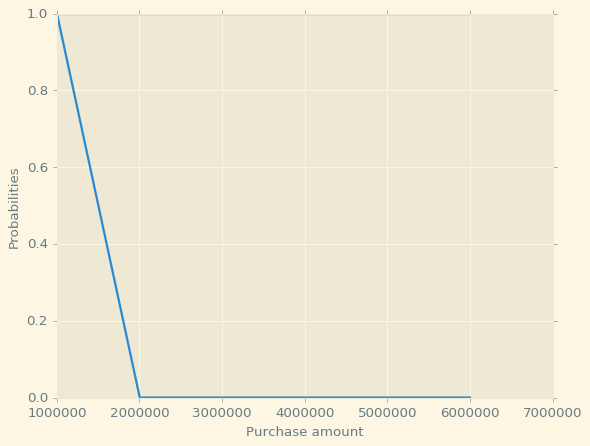

In [23]:
style.use('Solarize_Light2')
counts,bin_edges=np.histogram(historical_transactions['purchase_amount'],bins=6,density=True)
pdf=counts/sum(counts)
print(pdf)
print(bin_edges)

cdf=np.cumsum(pdf)
plt.plot(bin_edges[1:],pdf)
plt.plot(bin_edges[1:],cdf)
plt.xlabel('Purchase amount')
plt.ylabel('Probabilities')
plt.show();

This plot shows the main problem, seems as if there are outliers. The cumulative distribution is constant at prob of 1.So this plot hardly provides us any answers. Plus seems like most of the features are already scaled.

In [24]:
def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

historical_transactions = reduce_mem_usage(binarize(historical_transactions))
new_transactions =reduce_mem_usage(binarize(new_transactions))

def read_data(df):
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
    return df
#_________________________________________
train = reduce_mem_usage(read_data(train))
test = reduce_mem_usage(read_data(test))

target = train['target']
del train['target']

Mem. usage decreased to 1360.42 Mb (22.2% reduction)
Mem. usage decreased to 87.99 Mb (23.0% reduction)
Mem. usage decreased to  4.43 Mb (20.7% reduction)
Mem. usage decreased to  2.48 Mb (22.2% reduction)


##### Filling missing values present in the features using most common value.

In [25]:
for df in [historical_transactions,new_transactions]:
    df['category_2'].fillna(1.0,inplace=True)
    df['category_3'].fillna('A',inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

### Using purchase date we create multiple features such as year, week, hour,day ,weekend.Also we compute the monthly difference from today's date and add in the lag for accepting the transaction

In [26]:
for df in [historical_transactions,new_transactions]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']

### Now we will one hot encode the ordinal categories and use only authorized transactions

In [27]:
historical_transactions =reduce_mem_usage(pd.get_dummies(historical_transactions, columns=['category_2', 'category_3']))
new_transactions = reduce_mem_usage(pd.get_dummies(new_transactions, columns=['category_2', 'category_3']))

agg_fun = {'authorized_flag': ['mean']}
auth_mean = reduce_mem_usage(historical_transactions.groupby(['card_id']).agg(agg_fun))
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)

authorized_transactions = reduce_mem_usage(historical_transactions[historical_transactions['authorized_flag'] == 1])
historical_transactions =reduce_mem_usage(historical_transactions[historical_transactions['authorized_flag'] == 0])

Mem. usage decreased to 1527.00 Mb (46.6% reduction)
Mem. usage decreased to 99.22 Mb (47.5% reduction)
Mem. usage decreased to  3.10 Mb (37.5% reduction)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Mem. usage decreased to 1547.17 Mb (3.2% reduction)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Mem. usage decreased to 151.22 Mb (0.0% reduction)


In [28]:
authorized_transactions.head(10)

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,year,weekofyear,month,dayofweek,weekend,hour,month_diff,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C
0,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-8,-0.703125,2017-06-25 15:33:07,16,37,2017,25,6,6,1,15,13,1,0,0,0,0,1,0,0
1,1,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-7,-0.732910,2017-07-15 12:10:45,16,16,2017,28,7,5,1,12,14,1,0,0,0,0,1,0,0
2,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_979ed661fc,-6,-0.720215,2017-08-09 22:04:29,16,37,2017,32,8,2,0,22,14,1,0,0,0,0,1,0,0
3,1,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,16,34,2017,35,9,5,1,10,14,1,0,0,0,0,1,0,0
4,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-11,-0.722656,2017-03-10 01:14:19,16,37,2017,10,3,4,0,1,14,1,0,0,0,0,1,0,0
5,1,C_ID_4e6213e9bc,333,0,0,80,M_ID_50af771f8d,0,-0.734863,2018-02-24 08:45:05,9,37,2018,8,2,5,1,8,13,1,0,0,0,0,1,0,0
6,1,C_ID_4e6213e9bc,88,0,0,278,M_ID_5e8220e564,-11,-0.716797,2017-03-21 00:10:51,16,37,2017,12,3,1,0,0,14,1,0,0,0,0,1,0,0
7,1,C_ID_4e6213e9bc,3,0,0,80,M_ID_9d41786a50,-3,-0.657227,2017-11-18 20:05:55,16,37,2017,46,11,5,1,20,14,1,0,0,0,0,1,0,0
8,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_979ed661fc,-8,-0.737793,2017-06-01 22:02:56,16,37,2017,22,6,3,0,22,14,1,0,0,0,0,1,0,0
9,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_74ba14b5fc,-11,-0.715332,2017-03-16 15:41:22,16,37,2017,11,3,3,0,15,14,1,0,0,0,0,1,0,0


In [29]:
historical_transactions['purchase_month'] =historical_transactions['purchase_date'].dt.month
authorized_transactions['purchase_month'] = authorized_transactions['purchase_date'].dt.month
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month

In [30]:
def aggregate_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
    'category_1': ['sum', 'mean','count'],
    'category_2_1.0': ['mean','count'],
    'category_2_2.0': ['mean','count'],
    'category_2_3.0': ['mean','count'],
    'category_2_4.0': ['mean','count'],
    'category_2_5.0': ['mean','count'],
    'category_3_A': ['mean','count'],
    'category_3_B': ['mean','count'],
    'category_3_C': ['mean','count'],
    'merchant_id': ['nunique'],
    'merchant_category_id': ['nunique'],
    'state_id': ['nunique'],
    'city_id': ['nunique'],
    'subsector_id': ['nunique'],
    'purchase_amount': ['sum', 'mean','median','max', 'min', 'std'],
    'installments': ['sum', 'mean','median', 'max', 'min', 'std'],
    'purchase_month': ['mean', 'max', 'min', 'std'],
    'purchase_date': [np.ptp, 'min', 'max'],
    'month_lag': ['mean', 'max', 'min', 'std'],
    'month_diff': ['mean']
    }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

In [31]:
history = aggregate_transactions(historical_transactions)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]
history[:5]

,card_id,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_1_count,hist_category_2_1.0_mean,hist_category_2_1.0_count,hist_category_2_2.0_mean,hist_category_2_2.0_count,hist_category_2_3.0_mean,hist_category_2_3.0_count,hist_category_2_4.0_mean,hist_category_2_4.0_count,hist_category_2_5.0_mean,hist_category_2_5.0_count,hist_category_3_A_mean,hist_category_3_A_count,hist_category_3_B_mean,hist_category_3_B_count,hist_category_3_C_mean,hist_category_3_C_count,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_median,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_median,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_month_diff_mean
0,C_ID_00007093c1,35,4.0,0.114286,35,0.114286,35,0.000000,35,0.885714,35,0.0,35,0.000000,35,0.000000,35,0.828571,35,0.171429,35,11,8,2,3,7,-14.401965,-0.411485,-0.569219,1.507069,-0.728876,0.430059,45,1.285714,1.0,3,1,0.667367,5.914286,12,1,3.071419,28858113.0,1.489250e+09,1.518108e+09,-6.028571,0,-11,3.535415,13.828571
1,C_ID_0001238066,3,0.0,0.000000,3,0.333333,3,0.000000,3,0.000000,3,0.0,3,0.666667,3,0.000000,3,1.000000,3,0.000000,3,2,1,2,2,1,-1.789928,-0.596643,-0.596643,-0.596643,-0.596643,0.000000,3,1.000000,1.0,1,1,0.000000,8.666667,12,2,5.773503,3609150.0,1.514660e+09,1.518269e+09,-1.333333,0,-2,1.154701,13.333333
2,C_ID_0001506ef0,4,0.0,0.000000,4,0.000000,4,0.000000,4,1.000000,4,0.0,4,0.000000,4,0.750000,4,0.250000,4,0.000000,4,4,4,1,1,4,-2.905782,-0.726445,-0.728350,-0.708590,-0.740491,0.016203,1,0.250000,0.0,1,0,0.500000,5.500000,12,2,4.725816,22098875.0,1.496772e+09,1.518871e+09,-2.500000,0,-8,3.785939,14.000000
3,C_ID_0001793786,27,2.0,0.074074,27,0.592593,27,0.296296,27,0.111111,27,0.0,27,0.000000,27,0.814815,27,0.185185,27,0.000000,27,17,14,4,8,11,-11.825338,-0.437975,-0.566620,1.236592,-0.745405,0.498150,5,0.185185,0.0,1,0,0.395847,6.481481,9,3,2.375684,16780236.0,1.488636e+09,1.505416e+09,-3.518519,-1,-7,2.375684,17.851852
4,C_ID_000183fdda,7,0.0,0.000000,7,0.000000,7,0.000000,7,1.000000,7,0.0,7,0.000000,7,0.000000,7,0.428571,7,0.571429,7,4,4,1,1,4,-0.941381,-0.134483,-0.339389,0.334099,-0.714541,0.452741,19,2.714286,2.0,6,1,2.288689,8.285714,10,8,0.755929,6701589.0,1.502099e+09,1.508801e+09,-5.714286,-4,-6,0.755929,13.428571


In [32]:
authorized = aggregate_transactions(authorized_transactions)
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]
authorized[:5]

,card_id,auth_transactions_count,auth_category_1_sum,auth_category_1_mean,auth_category_1_count,auth_category_2_1.0_mean,auth_category_2_1.0_count,auth_category_2_2.0_mean,auth_category_2_2.0_count,auth_category_2_3.0_mean,auth_category_2_3.0_count,auth_category_2_4.0_mean,auth_category_2_4.0_count,auth_category_2_5.0_mean,auth_category_2_5.0_count,auth_category_3_A_mean,auth_category_3_A_count,auth_category_3_B_mean,auth_category_3_B_count,auth_category_3_C_mean,auth_category_3_C_count,auth_merchant_id_nunique,auth_merchant_category_id_nunique,auth_state_id_nunique,auth_city_id_nunique,auth_subsector_id_nunique,auth_purchase_amount_sum,auth_purchase_amount_mean,auth_purchase_amount_median,auth_purchase_amount_max,auth_purchase_amount_min,auth_purchase_amount_std,auth_installments_sum,auth_installments_mean,auth_installments_median,auth_installments_max,auth_installments_min,auth_installments_std,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_month_lag_mean,auth_month_lag_max,auth_month_lag_min,auth_month_lag_std,auth_month_diff_mean
0,C_ID_00007093c1,114,24.0,0.210526,114,0.210526,114,0.000000,114,0.780702,114,0.0,114,0.008772,114,0.000000,114,0.842105,114,0.157895,114,28,18,3,4,13,-62.437500,-0.547852,-0.596680,1.206055,-0.729004,0.237427,147,1.289474,1.0,6,1,0.795159,6.517544,12,1,3.371490,32627654.0,1.487081e+09,1.519708e+09,-5.798246,0,-12,3.441495,13.807018
1,C_ID_0001238066,120,2.0,0.016667,120,0.850000,120,0.000000,120,0.000000,120,0.0,120,0.150000,120,0.025000,120,0.708333,120,0.266667,120,65,29,6,18,17,-70.687500,-0.588867,-0.650391,0.768066,-0.734863,0.192627,195,1.625000,1.0,10,-1,1.501050,7.275000,12,1,4.895483,13110825.0,1.506638e+09,1.519748e+09,-1.825000,0,-5,1.294218,13.625000
2,C_ID_0001506ef0,62,0.0,0.000000,62,0.032258,62,0.000000,62,0.967742,62,0.0,62,0.000000,62,1.000000,62,0.000000,62,0.000000,62,28,19,2,3,12,-31.703125,-0.511230,-0.700195,1.493164,-0.740723,0.484619,0,0.000000,0.0,0,0,0.000000,6.887097,12,1,4.538017,34460275.0,1.484411e+09,1.518871e+09,-4.983871,0,-13,4.248402,13.870968
3,C_ID_0001793786,189,0.0,0.000000,189,0.576720,189,0.359788,189,0.063492,189,0.0,189,0.000000,189,1.000000,189,0.000000,189,0.000000,189,114,45,4,9,22,-24.968750,-0.132080,-0.447998,4.554688,-0.737793,0.868164,0,0.000000,0.0,0,0,0.000000,6.698413,10,1,2.301491,24487497.0,1.484994e+09,1.509481e+09,-3.301587,0,-9,2.301491,17.814815
4,C_ID_000183fdda,137,4.0,0.029197,137,0.080292,137,0.007299,137,0.905109,137,0.0,137,0.007299,137,0.029197,137,0.729927,137,0.240876,137,71,34,7,9,20,-67.875000,-0.495605,-0.670898,2.765625,-0.737793,0.523926,245,1.788321,1.0,10,-1,2.108912,6.810219,12,1,4.538289,15148616.0,1.504444e+09,1.519592e+09,-2.284672,0,-5,1.782055,13.788321


In [33]:
new = aggregate_transactions(new_transactions)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]
new[:5]

,card_id,new_transactions_count,new_category_1_sum,new_category_1_mean,new_category_1_count,new_category_2_1.0_mean,new_category_2_1.0_count,new_category_2_2.0_mean,new_category_2_2.0_count,new_category_2_3.0_mean,new_category_2_3.0_count,new_category_2_4.0_mean,new_category_2_4.0_count,new_category_2_5.0_mean,new_category_2_5.0_count,new_category_3_A_mean,new_category_3_A_count,new_category_3_B_mean,new_category_3_B_count,new_category_3_C_mean,new_category_3_C_count,new_merchant_id_nunique,new_merchant_category_id_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_median,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_mean,new_installments_median,new_installments_max,new_installments_min,new_installments_std,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_month_diff_mean
0,C_ID_00007093c1,2,0,0.000000,2,0.500000,2,0.000000,2,0.50000,2,0.0,2,0.000000,2,0.000000,2,1.000000,2,0.000000,2,2,2,2,2,2,-1.328125,-0.664062,-0.664062,-0.656738,-0.671875,0.010704,2,1.000000,1.0,1,1,0.000000,4.000000,4,4,0.000000,537024.0,1.522754e+09,1.523291e+09,2.000000,2,2,0.000000,14.000000
1,C_ID_0001238066,26,2,0.076923,26,0.884615,26,0.000000,26,0.00000,26,0.0,26,0.115385,26,0.038462,26,0.807692,26,0.153846,26,25,15,4,8,9,-14.851562,-0.571289,-0.649414,-0.078308,-0.740723,0.173462,42,1.615385,1.0,10,-1,2.079941,3.346154,4,3,0.485165,5195343.0,1.519923e+09,1.525118e+09,1.346154,2,1,0.485165,13.500000
2,C_ID_0001506ef0,2,0,0.000000,2,0.000000,2,0.000000,2,1.00000,2,0.0,2,0.000000,2,1.000000,2,0.000000,2,0.000000,2,2,2,1,1,2,-1.447266,-0.723633,-0.723633,-0.715332,-0.731934,0.011742,0,0.000000,0.0,0,0,0.000000,3.000000,3,3,0.000000,471152.0,1.521239e+09,1.521710e+09,1.000000,1,1,0.000000,13.500000
3,C_ID_0001793786,31,0,0.000000,31,0.548387,31,0.258065,31,0.16129,31,0.0,31,0.032258,31,1.000000,31,0.000000,31,0.000000,31,31,21,5,7,14,-0.229004,-0.007385,-0.372803,3.130859,-0.737793,0.947266,0,0.000000,0.0,0,0,0.000000,11.322581,12,11,0.475191,3981096.0,1.510761e+09,1.514742e+09,1.322581,2,1,0.475191,17.290323
4,C_ID_000183fdda,11,0,0.000000,11,0.000000,11,0.000000,11,1.00000,11,0.0,11,0.000000,11,0.090909,11,0.545455,11,0.363636,11,11,9,2,2,6,-6.589844,-0.599121,-0.665527,-0.107666,-0.732422,0.182861,16,1.454545,1.0,4,-1,1.293340,3.272727,4,3,0.467099,5106807.0,1.519994e+09,1.525100e+09,1.272727,2,1,0.467099,13.727273


In [34]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'median', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean','median','min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group
#___________________________________________________________
final_group =  aggregate_per_month(authorized_transactions) 
final_group[:10]

,card_id,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_median_mean,purchase_amount_median_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_median_mean,installments_median_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,C_ID_00007093c1,-6.000000,3.894440,8.769231,3.539158,-4.804688,2.175781,-0.536133,0.075317,-0.593750,0.079956,-0.702637,0.041229,-0.126709,0.446045,0.197266,0.120178,8.769231,3.539158,11.307692,4.210792,1.369646,0.423190,1.115385,0.299572,1.000000,0.000000,2.538462,1.613246,0.625428,0.675607
1,C_ID_0001238066,-2.500000,1.870829,20.000000,11.696153,-11.781250,6.679688,-0.603516,0.046021,-0.650391,0.008392,-0.730469,0.002686,-0.161011,0.485840,0.151367,0.093811,20.000000,11.696153,32.500000,24.501020,1.652873,0.410539,1.166667,0.408248,0.666667,0.816497,4.666667,2.875181,1.256525,0.521292
2,C_ID_0001506ef0,-6.230769,4.225988,4.769231,4.342692,-2.437500,2.902344,-0.446777,0.271240,-0.559570,0.272949,-0.725586,0.011238,0.161377,0.748535,0.496338,0.415039,4.769231,4.342692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,C_ID_0001793786,-4.500000,3.027650,18.900000,12.160501,-2.496094,4.019531,-0.005669,0.271240,-0.307129,0.310303,-0.646484,0.166260,2.191406,1.291016,0.880371,0.259033,18.900000,12.160501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,C_ID_000183fdda,-2.500000,1.870829,22.833333,7.167054,-11.312500,4.800781,-0.489258,0.140991,-0.652832,0.036041,-0.728516,0.009804,1.152344,1.062500,0.472168,0.315430,22.833333,7.167054,40.833333,14.048725,1.834943,0.362557,1.000000,0.000000,0.333333,1.032796,9.166667,2.041241,2.144389,0.665529
5,C_ID_00024e244b,-6.384615,4.330867,4.076923,4.290717,-2.556641,2.089844,-0.685059,0.071899,-0.718750,0.017639,-0.729004,0.016037,-0.425293,0.813477,0.108459,0.208740,4.076923,4.290717,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,C_ID_0002709b5a,-5.000000,3.316625,6.090909,3.505839,-3.994141,2.439453,-0.638672,0.060883,-0.651367,0.064575,-0.700195,0.030731,-0.545898,0.092529,0.076294,0.051697,6.090909,3.505839,10.727273,8.427229,1.965729,1.287108,1.454545,0.850134,0.818182,0.603023,3.818182,3.341203,1.600058,1.734256
7,C_ID_00027503e2,-4.000000,2.738613,2.666667,1.224745,-1.974609,0.909668,-0.740234,0.002453,-0.740234,0.002939,-0.742188,0.003126,-0.737793,0.002584,0.003202,0.001064,2.666667,1.224745,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,C_ID_000298032a,-5.250000,4.334249,3.500000,1.772811,-1.844727,0.698730,-0.590332,0.168091,-0.647461,0.028946,-0.686523,0.020416,-0.210205,1.127930,0.213989,0.442383,3.500000,1.772811,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,C_ID_0002ba3c2e,-4.666667,3.141125,9.166667,4.665476,-5.843750,3.021484,-0.638184,0.044952,-0.677734,0.025406,-0.721680,0.025970,-0.387207,0.222290,0.107422,0.060822,9.166667,4.665476,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [35]:
def successive_aggregates(df, field1, field2):
    t = df.groupby(['card_id', field1])[field2].mean()
    u = pd.DataFrame(t).reset_index().groupby('card_id')[field2].agg(['mean', 'min', 'max', 'std'])
    u.columns = [field1 + '_' + field2 + '_' + col for col in u.columns.values]
    u.reset_index(inplace=True)
    return u


additional_fields = successive_aggregates(new_transactions, 'category_1', 'purchase_amount')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'installments', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'city_id', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'category_1', 'installments'),
                                            on = 'card_id', how='left')

In [36]:
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, authorized, on='card_id', how='left')
test = pd.merge(test, authorized, on='card_id', how='left')

train = pd.merge(train, new, on='card_id', how='left')
test = pd.merge(test, new, on='card_id', how='left')

train = pd.merge(train, final_group, on='card_id', how='left')
test = pd.merge(test, final_group, on='card_id', how='left')

train = pd.merge(train, auth_mean, on='card_id', how='left')
test = pd.merge(test, auth_mean, on='card_id', how='left')

train = pd.merge(train, additional_fields, on='card_id', how='left')
test = pd.merge(test, additional_fields, on='card_id', how='left')

In [37]:
train.describe()

,feature_1,feature_2,feature_3,elapsed_time,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_1_count,hist_category_2_1.0_mean,hist_category_2_1.0_count,hist_category_2_2.0_mean,hist_category_2_2.0_count,hist_category_2_3.0_mean,hist_category_2_3.0_count,hist_category_2_4.0_mean,hist_category_2_4.0_count,hist_category_2_5.0_mean,hist_category_2_5.0_count,hist_category_3_A_mean,hist_category_3_A_count,hist_category_3_B_mean,hist_category_3_B_count,hist_category_3_C_mean,hist_category_3_C_count,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_median,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_median,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_month_diff_mean,auth_transactions_count,auth_category_1_sum,auth_category_1_mean,auth_category_1_count,auth_category_2_1.0_mean,auth_category_2_1.0_count,auth_category_2_2.0_mean,auth_category_2_2.0_count,auth_category_2_3.0_mean,auth_category_2_3.0_count,auth_category_2_4.0_mean,auth_category_2_4.0_count,auth_category_2_5.0_mean,auth_category_2_5.0_count,auth_category_3_A_mean,auth_category_3_A_count,auth_category_3_B_mean,auth_category_3_B_count,auth_category_3_C_mean,auth_category_3_C_count,auth_merchant_id_nunique,auth_merchant_category_id_nunique,auth_state_id_nunique,auth_city_id_nunique,auth_subsector_id_nunique,auth_purchase_amount_sum,auth_purchase_amount_mean,auth_purchase_amount_median,auth_purchase_amount_max,auth_purchase_amount_min,auth_purchase_amount_std,auth_installments_sum,auth_installments_mean,auth_installments_median,auth_installments_max,auth_installments_min,auth_installments_std,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_month_lag_mean,auth_month_lag_max,auth_month_lag_min,auth_month_lag_std,auth_month_diff_mean,new_transactions_count,new_category_1_sum,new_category_1_mean,new_category_1_count,new_category_2_1.0_mean,new_category_2_1.0_count,new_category_2_2.0_mean,new_category_2_2.0_count,new_category_2_3.0_mean,new_category_2_3.0_count,new_category_2_4.0_mean,new_category_2_4.0_count,new_category_2_5.0_mean,new_category_2_5.0_count,new_category_3_A_mean,new_category_3_A_count,new_category_3_B_mean,new_category_3_B_count,new_category_3_C_mean,new_category_3_C_count,new_merchant_id_nunique,new_merchant_category_id_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_median,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_mean,new_installments_median,new_installments_max,new_installments_min,new_installments_std,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_month_diff_mean,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_median_mean,purchase_amount_median_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_

#### Seems like there are a lot of missing values in our dataset

In [38]:
for i in train.columns:
    if train[i].isna().sum()>0:
        train[i].fillna(0,inplace=True)

for i in test.columns:
    if test[i].isna().sum()>0:
        test[i].fillna(0,inplace=True)

In [39]:
test.columns

Index(['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3',
       'elapsed_time', 'hist_transactions_count', 'hist_category_1_sum',
       'hist_category_1_mean', 'hist_category_1_count',
       ...
       'installments_purchase_amount_max', 'installments_purchase_amount_std',
       'city_id_purchase_amount_mean', 'city_id_purchase_amount_min',
       'city_id_purchase_amount_max', 'city_id_purchase_amount_std',
       'category_1_installments_mean', 'category_1_installments_min',
       'category_1_installments_max', 'category_1_installments_std'],
      dtype='object', length=200)

In [40]:
train.columns

Index(['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3',
       'elapsed_time', 'hist_transactions_count', 'hist_category_1_sum',
       'hist_category_1_mean', 'hist_category_1_count',
       ...
       'installments_purchase_amount_max', 'installments_purchase_amount_std',
       'city_id_purchase_amount_mean', 'city_id_purchase_amount_min',
       'city_id_purchase_amount_max', 'city_id_purchase_amount_std',
       'category_1_installments_mean', 'category_1_installments_min',
       'category_1_installments_max', 'category_1_installments_std'],
      dtype='object', length=200)

In [41]:
train['transactions_ratio'] = train['new_transactions_count'] / train['hist_transactions_count']
test['transactions_ratio'] = test['new_transactions_count'] / test['hist_transactions_count']

In [42]:
hist_columns = [(c, c.replace('new', 'auth')) for c in train.columns if 'hist' in c]
for c in hist_columns:
    col_name = 'ratio_{}_{}'.format(c[0], c[1])
    train[col_name] = train[c[0]] / train[c[1]]
    test[col_name] = test[c[0]] / test[c[1]]

In [43]:
param = {'num_leaves': 112,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 10,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [44]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
#features = [f for f in features if f not in unimportant_features]
categorical_feats = ['feature_2', 'feature_3']

In [45]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.71402	valid_1's rmse: 3.77713
[200]	training's rmse: 3.64424	valid_1's rmse: 3.72925
[300]	training's rmse: 3.59875	valid_1's rmse: 3.7059
[400]	training's rmse: 3.56625	valid_1's rmse: 3.69365
[500]	training's rmse: 3.54055	valid_1's rmse: 3.68641
[600]	training's rmse: 3.51887	valid_1's rmse: 3.68167
[700]	training's rmse: 3.50164	valid_1's rmse: 3.67855
[800]	training's rmse: 3.48496	valid_1's rmse: 3.67665
[900]	training's rmse: 3.46893	valid_1's rmse: 3.67508
[1000]	training's rmse: 3.45496	valid_1's rmse: 3.67411
[1100]	training's rmse: 3.44122	valid_1's rmse: 3.67338
[1200]	training's rmse: 3.42849	valid_1's rmse: 3.67306
[1300]	training's rmse: 3.41695	valid_1's rmse: 3.67278
[1400]	training's rmse: 3.40449	valid_1's rmse: 3.6726
[1500]	training's rmse: 3.39291	valid_1's rmse: 3.67267
[1600]	training's rmse: 3.38207	valid_1's rmse: 3.67251
[1700]	training's rmse: 3.37122	valid_1's rmse: 3.67

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.73123	valid_1's rmse: 3.70428
[200]	training's rmse: 3.65948	valid_1's rmse: 3.65986
[300]	training's rmse: 3.6137	valid_1's rmse: 3.63911
[400]	training's rmse: 3.5802	valid_1's rmse: 3.62901
[500]	training's rmse: 3.55391	valid_1's rmse: 3.62308
[600]	training's rmse: 3.53271	valid_1's rmse: 3.6195
[700]	training's rmse: 3.51375	valid_1's rmse: 3.61663
[800]	training's rmse: 3.49591	valid_1's rmse: 3.61525
[900]	training's rmse: 3.48147	valid_1's rmse: 3.6146
[1000]	training's rmse: 3.46735	valid_1's rmse: 3.61409
[1100]	training's rmse: 3.4536	valid_1's rmse: 3.61326
[1200]	training's rmse: 3.44011	valid_1's rmse: 3.61309
[1300]	training's rmse: 3.42882	valid_1's rmse: 3.61294
[1400]	training's rmse: 3.41604	valid_1's rmse: 3.61343
Early stopping, best iteration is:
[1292]	training's rmse: 3.42955	valid_1's rmse: 3.61291
fold n°2


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.73482	valid_1's rmse: 3.68131
[200]	training's rmse: 3.66265	valid_1's rmse: 3.64087
[300]	training's rmse: 3.61663	valid_1's rmse: 3.62159
[400]	training's rmse: 3.58301	valid_1's rmse: 3.6126
[500]	training's rmse: 3.55657	valid_1's rmse: 3.6069
[600]	training's rmse: 3.53498	valid_1's rmse: 3.60363
[700]	training's rmse: 3.51576	valid_1's rmse: 3.60096
[800]	training's rmse: 3.49882	valid_1's rmse: 3.59935
[900]	training's rmse: 3.48289	valid_1's rmse: 3.59816
[1000]	training's rmse: 3.46881	valid_1's rmse: 3.59738
[1100]	training's rmse: 3.45585	valid_1's rmse: 3.59708
[1200]	training's rmse: 3.44362	valid_1's rmse: 3.59711
[1300]	training's rmse: 3.43156	valid_1's rmse: 3.59719
[1400]	training's rmse: 3.41929	valid_1's rmse: 3.5974
Early stopping, best iteration is:
[1235]	training's rmse: 3.43955	valid_1's rmse: 3.59697
fold n°3


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.68679	valid_1's rmse: 3.8802
[200]	training's rmse: 3.61598	valid_1's rmse: 3.83279
[300]	training's rmse: 3.57033	valid_1's rmse: 3.80993
[400]	training's rmse: 3.53704	valid_1's rmse: 3.79848
[500]	training's rmse: 3.5104	valid_1's rmse: 3.79229
[600]	training's rmse: 3.48857	valid_1's rmse: 3.78873
[700]	training's rmse: 3.47078	valid_1's rmse: 3.78663
[800]	training's rmse: 3.45421	valid_1's rmse: 3.78534
[900]	training's rmse: 3.43909	valid_1's rmse: 3.78378
[1000]	training's rmse: 3.42581	valid_1's rmse: 3.78345
[1100]	training's rmse: 3.4117	valid_1's rmse: 3.78308
[1200]	training's rmse: 3.39871	valid_1's rmse: 3.78351
Early stopping, best iteration is:
[1071]	training's rmse: 3.41588	valid_1's rmse: 3.78305
fold n°4


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.73226	valid_1's rmse: 3.69482
[200]	training's rmse: 3.65974	valid_1's rmse: 3.6538
[300]	training's rmse: 3.61333	valid_1's rmse: 3.63585
[400]	training's rmse: 3.57944	valid_1's rmse: 3.62677
[500]	training's rmse: 3.55313	valid_1's rmse: 3.62228
[600]	training's rmse: 3.53186	valid_1's rmse: 3.61907
[700]	training's rmse: 3.51422	valid_1's rmse: 3.61779
[800]	training's rmse: 3.49804	valid_1's rmse: 3.61696
[900]	training's rmse: 3.48255	valid_1's rmse: 3.61658
[1000]	training's rmse: 3.46865	valid_1's rmse: 3.61611
[1100]	training's rmse: 3.45564	valid_1's rmse: 3.61597
[1200]	training's rmse: 3.44146	valid_1's rmse: 3.61586
[1300]	training's rmse: 3.43012	valid_1's rmse: 3.61582
[1400]	training's rmse: 3.41805	valid_1's rmse: 3.6158
[1500]	training's rmse: 3.40669	valid_1's rmse: 3.61622
Early stopping, best iteration is:
[1352]	training's rmse: 3.4238	valid_1's rmse: 3.61574
CV score: 3.65684 

/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


In [47]:
mean_squared_error(oof, target)**0.5

/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


3.6568381236623573

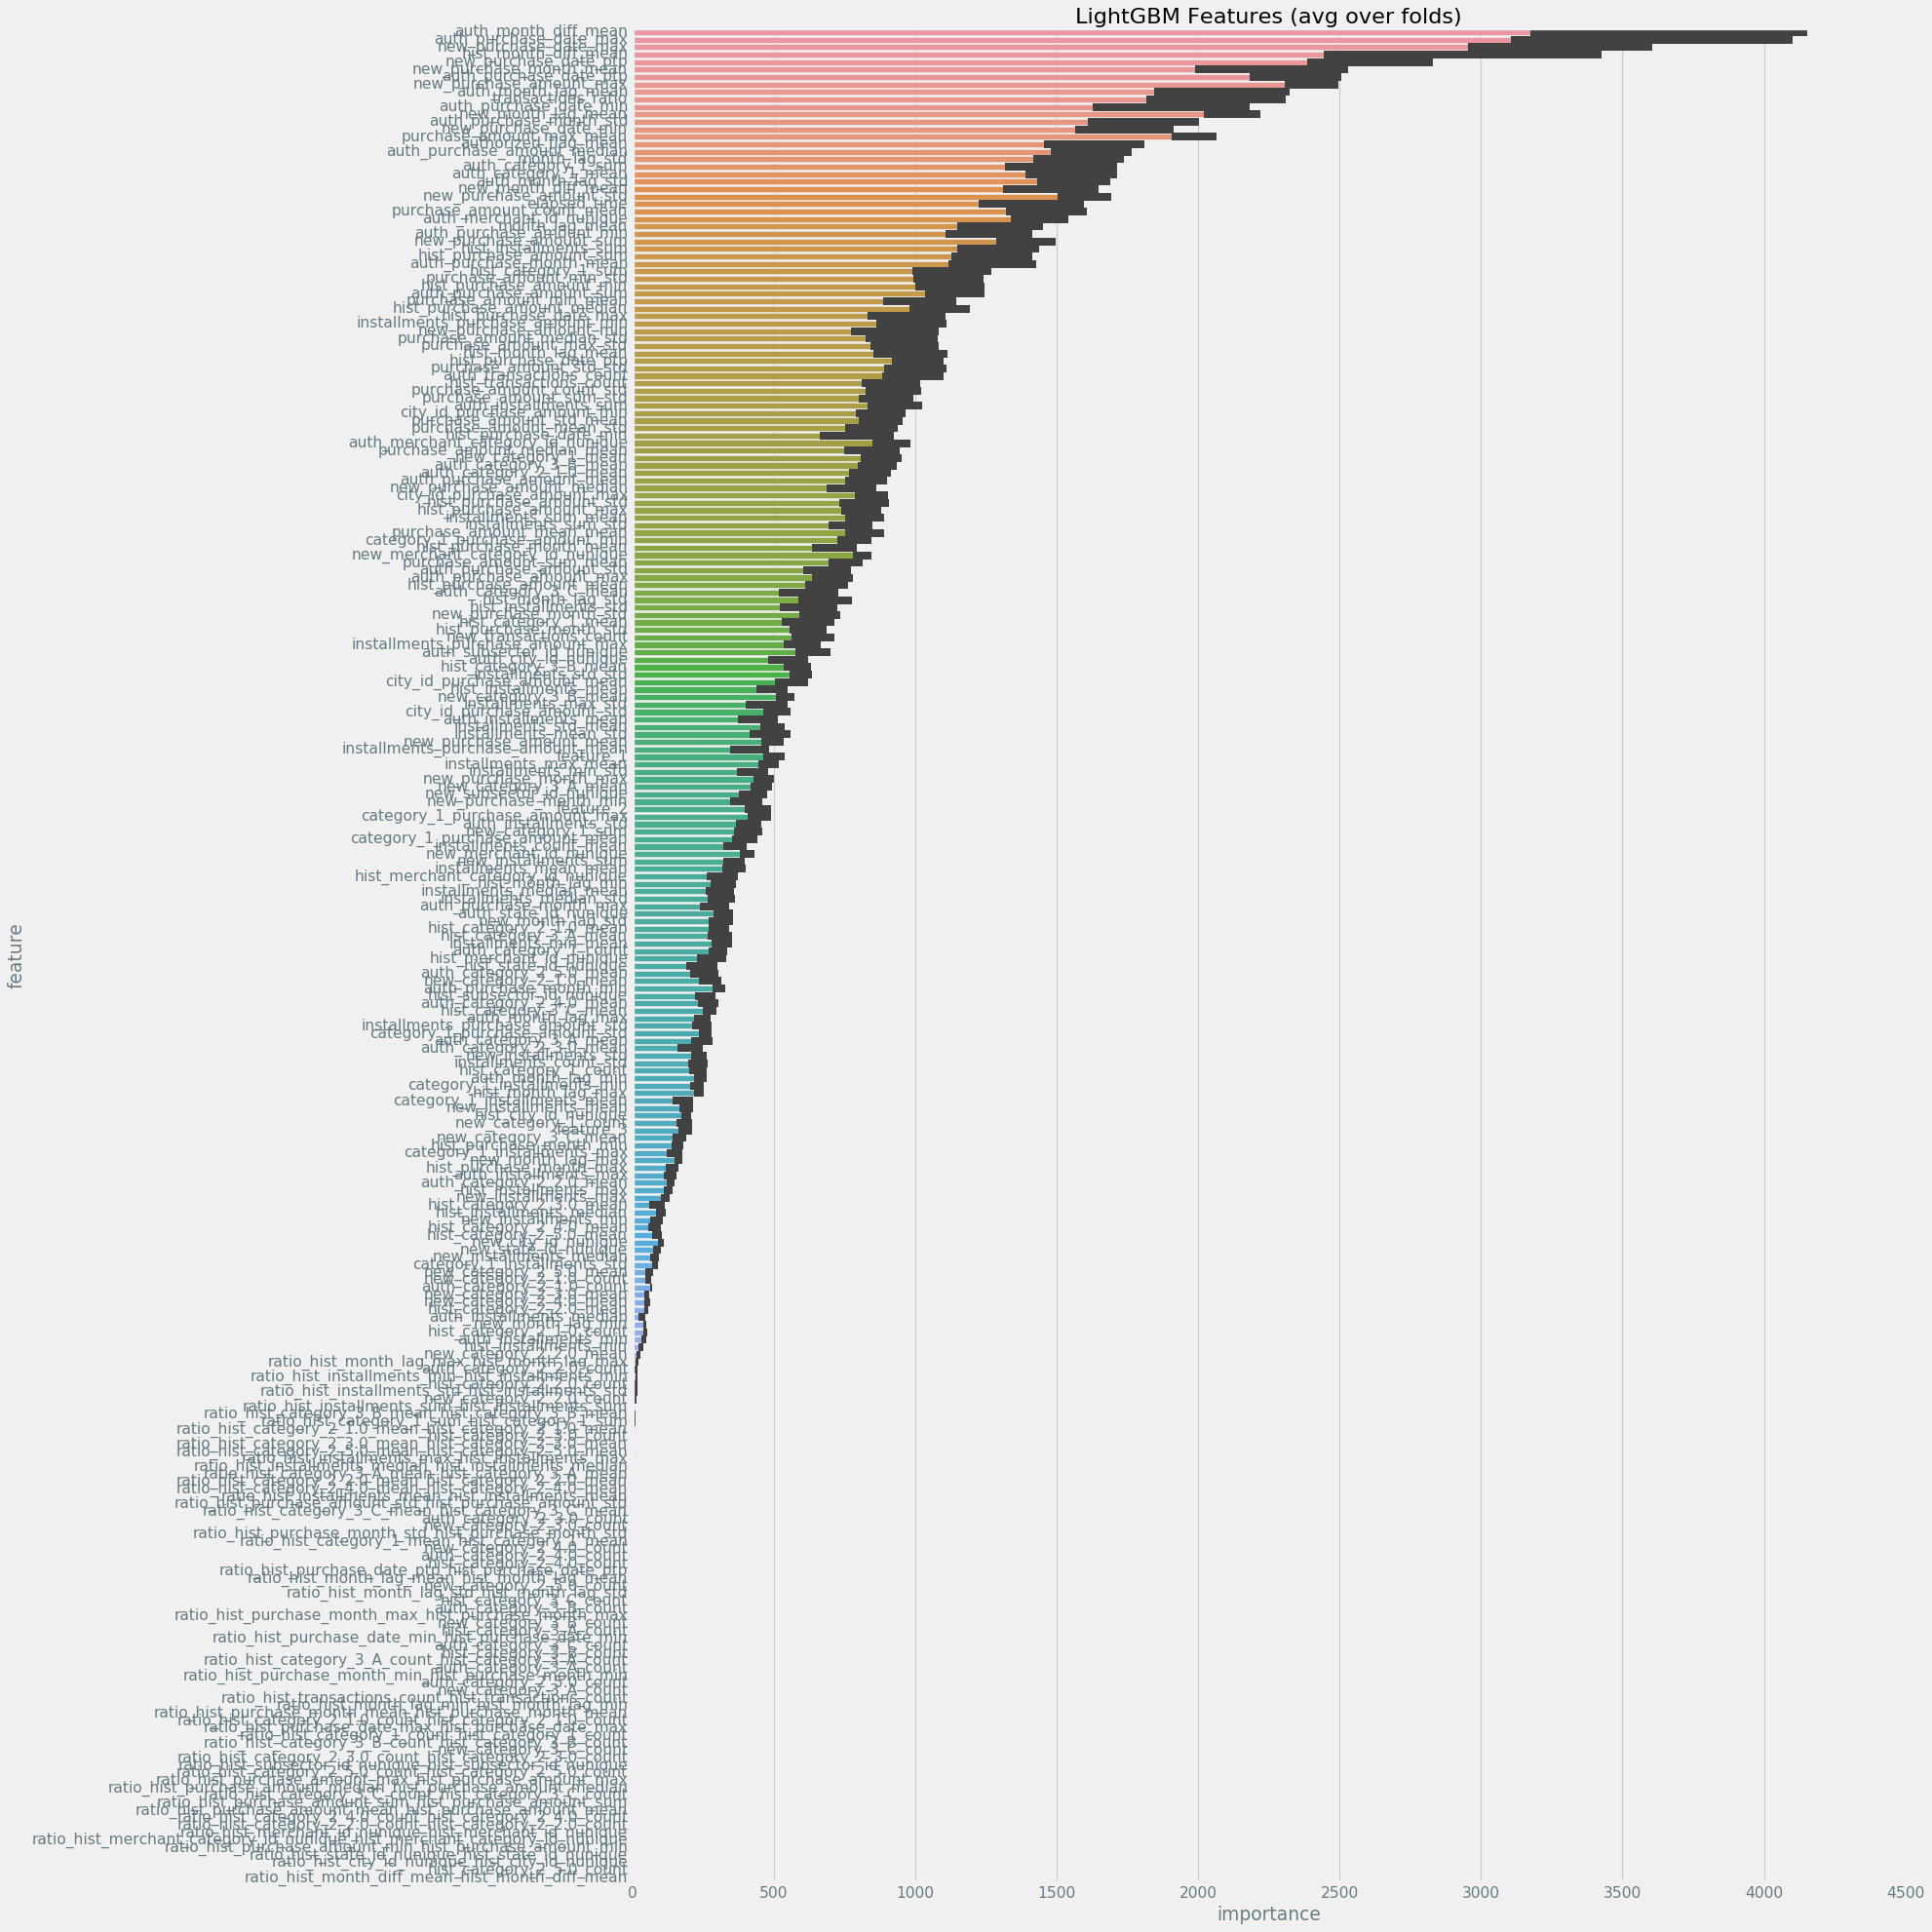

In [46]:
style.use('fivethirtyeight')
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(25,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [48]:

print(len(best_features.sort_values(by="importance",ascending=False)))
best_features.sort_values(by="importance",ascending=False)

1240


,feature,importance,fold
101,auth_month_diff_mean,4686,1
96,auth_purchase_date_max,4660,1
145,new_purchase_date_max,3883,1
52,hist_month_diff_mean,3819,1
101,auth_month_diff_mean,3763,5
96,auth_purchase_date_max,3723,5
101,auth_month_diff_mean,3559,2
96,auth_purchase_date_max,3420,2
96,auth_purchase_date_max,3405,3
101,auth_month_diff_mean,3355,3


In [49]:
best_features.loc[(best_features.importance>1000) & (best_features.fold==5),:].sort_values(by='importance',ascending=False)

,feature,importance,fold
101,auth_month_diff_mean,3763,5
96,auth_purchase_date_max,3723,5
145,new_purchase_date_max,3288,5
52,hist_month_diff_mean,2821,5
143,new_purchase_date_ptp,2799,5
130,new_purchase_amount_max,2418,5
94,auth_purchase_date_ptp,2273,5
139,new_purchase_month_mean,2194,5
97,auth_month_lag_mean,2065,5
146,new_month_lag_mean,2058,5


In [50]:
features_to_be_reused=best_features.loc[(best_features.importance>1000) & (best_features.fold==5),:].sort_values(by='importance',ascending=False)['feature']

In [56]:
data=best_features.loc[(best_features.importance>1000) & (best_features.fold==5),:].sort_values(by='importance',ascending=False)

In [57]:
data.head(10)

,feature,importance,fold
101,auth_month_diff_mean,3763,5
96,auth_purchase_date_max,3723,5
145,new_purchase_date_max,3288,5
52,hist_month_diff_mean,2821,5
143,new_purchase_date_ptp,2799,5
130,new_purchase_amount_max,2418,5
94,auth_purchase_date_ptp,2273,5
139,new_purchase_month_mean,2194,5
97,auth_month_lag_mean,2065,5
146,new_month_lag_mean,2058,5


In [58]:
train[features_to_be_reused].head(10)

,auth_month_diff_mean,auth_purchase_date_max,new_purchase_date_max,hist_month_diff_mean,new_purchase_date_ptp,new_purchase_amount_max,auth_purchase_date_ptp,new_purchase_month_mean,auth_month_lag_mean,new_month_lag_mean,purchase_amount_max_mean,transactions_ratio,auth_purchase_date_min,auth_purchase_month_std,new_purchase_date_min,new_purchase_amount_std,auth_category_1_sum,auth_category_1_mean,auth_month_lag_std,authorized_flag_mean,auth_purchase_amount_median,month_lag_std,elapsed_time,purchase_amount_count_mean,new_month_diff_mean,new_purchase_amount_sum,auth_merchant_id_nunique,hist_installments_sum,auth_purchase_month_mean,hist_purchase_amount_sum,month_lag_mean,auth_purchase_amount_min,auth_purchase_amount_sum,hist_purchase_amount_median,purchase_amount_min_std,hist_month_lag_mean,hist_purchase_amount_min,purchase_amount_std_std,auth_installments_sum,auth_transactions_count,hist_category_1_sum,installments_purchase_amount_min,hist_purchase_date_ptp
0,13.732794,1.519551e+09,1.525001e+09,13.846154,4742309.0,-0.296143,20977987.0,3.478261,-3.882591,1.478261,-0.158936,1.769231,1.498573e+09,3.528570,1.520259e+09,0.135742,0.0,0.000000,2.429155,0.950195,-0.697266,2.738613,245,27.444444,13.695652,-13.242188,93,4.0,7.979757,-8.571723,-4.000000,-0.739258,-157.375000,-0.708755,0.008781,-4.461538,-0.737892,0.119202,0,247,0.0,-0.575684,14254523.0
1,14.725664,1.517438e+09,1.522393e+09,14.545455,4887632.0,-0.701660,33717687.0,2.500000,-5.050147,1.500000,0.510742,0.545455,1.483720e+09,3.859177,1.517505e+09,0.014381,29.0,0.085546,3.836969,0.968750,-0.708984,3.894440,396,26.076923,14.833333,-4.355469,141,42.0,6.144543,-1.122886,-6.000000,-0.742188,-208.875000,-0.341192,0.005043,-4.454545,-0.740897,0.283936,501,339,2.0,-0.726074,25890841.0
2,13.707317,1.519759e+09,1.524937e+09,14.000000,0.0,-0.700195,35635623.0,4.000000,-8.487805,2.000000,-0.621094,0.500000,1.484123e+09,3.329836,1.524937e+09,0.000000,0.0,0.000000,3.893083,0.953613,-0.698730,4.396969,549,3.416667,13.000000,-0.700195,13,0.0,4.634146,-1.338967,-6.666667,-0.729980,-27.828125,-0.669484,0.018814,-11.000000,-0.701453,0.119080,0,41,0.0,-0.700195,4922885.0
3,13.610390,1.519818e+09,1.524049e+09,0.000000,3625505.0,-0.566895,13375339.0,3.714286,-2.831169,1.714286,-0.097351,inf,1.506443e+09,3.904797,1.520424e+09,0.065918,12.0,0.155844,1.802065,1.000000,-0.708008,1.870829,153,12.833333,13.857143,-4.656250,50,0.0,7.740260,0.000000,-2.500000,-0.740723,-49.500000,0.000000,0.009056,0.000000,0.000000,0.277344,84,77,0.0,-0.681152,0.0
4,13.632812,1.519850e+09,1.524941e+09,13.400000,4949682.0,0.450928,9405641.0,3.555556,-1.320312,1.555556,2.259766,7.200000,1.510445e+09,5.041261,1.519992e+09,0.223877,12.0,0.093750,1.026680,0.962402,-0.692871,1.290994,92,32.000000,13.777778,-19.921875,65,38.0,5.554688,20.352808,-1.500000,-0.746094,-69.062500,6.992617,0.016296,-0.400000,-0.512945,0.578125,144,128,3.0,-0.571289,3274330.0
5,20.750000,1.501343e+09,1.505510e+09,20.000000,2717302.0,-0.000090,17274145.0,8.750000,-2.593750,1.750000,-0.240112,4.000000,1.484068e+09,2.045599,1.502792e+09,0.280273,1.0,0.031250,2.045599,0.969727,-0.425781,2.160247,518,4.571429,21.000000,-1.399414,22,1.0,4.406250,-0.611669,-3.000000,-0.679199,-13.164062,-0.611669,0.092896,-1.000000,-0.611669,0.085510,98,32,0.0,-0.654297,0.0
6,13.872428,1.519402e+09,1.523037e+09,13.823529,2697311.0,-0.688477,35783408.0,3.200000,-6.572016,1.200000,-0.635254,0.294118,1.483619e+09,3.977469,1.520340e+09,0.019592,0.0,0.000000,4.223845,0.934570,-0.721191,4.183300,427,17.357143,14.000000,-3.601562,62,0.0,6.045267,-12.256299,-6.500000,-0.742188,-173.125000,-0.721363,0.002806,-7.705882,-0.739785,0.012108,0,243,0.0,-0.720703,32150370.0
7,15.421053,1.513885e+09,1.518986e+09,15.666667,1085016.0,-0.697266,7251596.0,2.000000,-1.684211,2.000000,-0.347900,1.000000,1.506634e+09,1.056863,1.517901e+09,0.002197,0.0,0.000000,1.056863,0.863770,-0.671875,1.290994,153,4.750000,16.000000,-2.097656,9,0.0,10.315789,-2.045754,-1.500000,-0.745605,-11.523438,-0.650738,0.0422

In [59]:
test[features_to_be_reused].head(10)

,auth_month_diff_mean,auth_purchase_date_max,new_purchase_date_max,hist_month_diff_mean,new_purchase_date_ptp,new_purchase_amount_max,auth_purchase_date_ptp,new_purchase_month_mean,auth_month_lag_mean,new_month_lag_mean,purchase_amount_max_mean,transactions_ratio,auth_purchase_date_min,auth_purchase_month_std,new_purchase_date_min,new_purchase_amount_std,auth_category_1_sum,auth_category_1_mean,auth_month_lag_std,authorized_flag_mean,auth_purchase_amount_median,month_lag_std,elapsed_time,purchase_amount_count_mean,new_month_diff_mean,new_purchase_amount_sum,auth_merchant_id_nunique,hist_installments_sum,auth_purchase_month_mean,hist_purchase_amount_sum,month_lag_mean,auth_purchase_amount_min,auth_purchase_amount_sum,hist_purchase_amount_median,purchase_amount_min_std,hist_month_lag_mean,hist_purchase_amount_min,purchase_amount_std_std,auth_installments_sum,auth_transactions_count,hist_category_1_sum,installments_purchase_amount_min,hist_purchase_date_ptp
0,15.750000,1.514510e+09,1.519845e+09,15.750000,2193863.0,-0.383301,23179380.0,2.000000,-3.477273,2.000000,-0.458740,0.125000,1.491330e+09,2.574370,1.517651e+09,0.182861,10.0,0.227273,2.574370,0.646973,-0.701660,2.738613,306.0,4.888889,15.666667,-1.777344,23,78.0,8.522727,-12.695209,-4.000000,-0.744141,-28.031250,-0.620009,0.008751,-3.916667,-0.728876,0.148193,63,44,13.0,-0.697266,19882897.0
1,13.909091,1.518989e+09,1.524247e+09,14.000000,4167689.0,-0.506348,34667913.0,3.444444,-10.428571,1.444444,-0.266113,9.000000,1.484321e+09,1.351438,1.520080e+09,0.071167,1.0,0.012987,2.172971,0.987305,-0.679199,4.708149,396.0,12.833333,14.000000,-5.945312,27,1.0,3.259740,-0.731881,-9.166667,-0.731934,-48.406250,-0.731881,0.020081,-9.000000,-0.731881,0.060883,82,77,1.0,-0.679688,0.0
2,13.777778,1.517598e+09,1.520947e+09,14.000000,1030753.0,0.904297,13924886.0,3.000000,-2.777778,1.000000,0.085144,0.500000,1.503673e+09,3.218868,1.519916e+09,1.152344,1.0,0.111111,1.641476,0.692383,-0.221680,2.236068,184.0,1.800000,14.000000,0.179688,7,18.0,9.888889,5.423384,-3.000000,-0.536621,-0.894531,1.341447,0.380127,-0.500000,0.214624,0.086487,26,9,0.0,-0.724609,1912092.0
3,13.807692,1.519127e+09,1.524000e+09,0.000000,3838554.0,-0.447998,6734846.0,3.300000,-1.230769,1.300000,-0.123047,inf,1.512392e+09,5.136296,1.520162e+09,0.073181,0.0,0.000000,0.951113,1.000000,-0.587402,1.000000,62.0,8.666667,13.800000,-5.746094,23,0.0,7.692308,0.000000,-1.000000,-0.731934,-13.695312,0.000000,0.115540,0.000000,0.000000,0.143799,38,26,0.0,-0.601074,0.0
4,13.758621,1.519728e+09,1.523535e+09,13.956522,3402694.0,14.281250,36174127.0,3.166667,-5.333333,1.166667,4.656250,0.260870,1.483554e+09,3.389371,1.520132e+09,6.027344,0.0,0.000000,4.222494,0.791016,-0.626465,4.183300,793.0,6.214286,14.000000,12.062500,45,24.0,5.356322,-15.562026,-6.500000,-0.745605,40.687500,-0.743903,2.566406,-9.608696,-0.746758,2.533203,96,87,0.0,-0.676758,31547941.0
5,13.250000,1.519838e+09,1.520852e+09,14.000000,0.0,-0.175903,20009278.0,3.000000,-2.916667,1.000000,0.063354,0.250000,1.499828e+09,4.501683,1.520852e+09,0.000000,1.0,0.083333,2.539088,0.750000,-0.073730,2.563480,215.0,1.714286,14.000000,-0.175903,10,5.0,7.083333,0.348254,-3.285714,-0.578613,-1.180664,0.139656,0.322754,-2.250000,-0.070715,0.257080,16,12,0.0,-0.175903,13240516.0
6,13.479167,1.519569e+09,1.524562e+09,0.000000,4543448.0,-0.019623,11997304.0,3.666667,-1.750000,1.666667,0.172363,inf,1.507572e+09,4.940066,1.520019e+09,0.180420,1.0,0.020833,1.391463,1.000000,-0.491699,1.581139,123.0,9.600000,13.666667,-4.312500,25,0.0,6.750000,0.000000,-2.000000,-0.684082,-18.609375,0.000000,0.093079,0.000000,0.000000,0.270020,73,48,0.0,-0.541992,0.0
7,13.800000,1.516717e+09,0.000000e+00,13.600000,0.0,0.000000,30253862.0,0.000000,-5.933333,0.000000,-0.659668,0.000000,1.486464e+09,4.237025,0.000000e+00,0.000000,0.0,0.000000,4.317186,0.750000,-0.719727,4.461475,365.0,2.142857,0.000000,0.000000,6,0.0,5.666667,-3.345052,-6.714286,-0.741211,-10.453125,-0.733534,0.012817,-3.600000,-0.739169,0.079102,0

In [52]:
feature_importance_df.head(10)

,feature,importance,fold
0,feature_1,553,1
1,feature_2,507,1
2,feature_3,216,1
3,elapsed_time,1717,1
4,hist_transactions_count,1133,1
5,hist_category_1_sum,1392,1
6,hist_category_1_mean,770,1
7,hist_category_1_count,285,1
8,hist_category_2_1.0_mean,374,1
9,hist_category_2_1.0_count,53,1


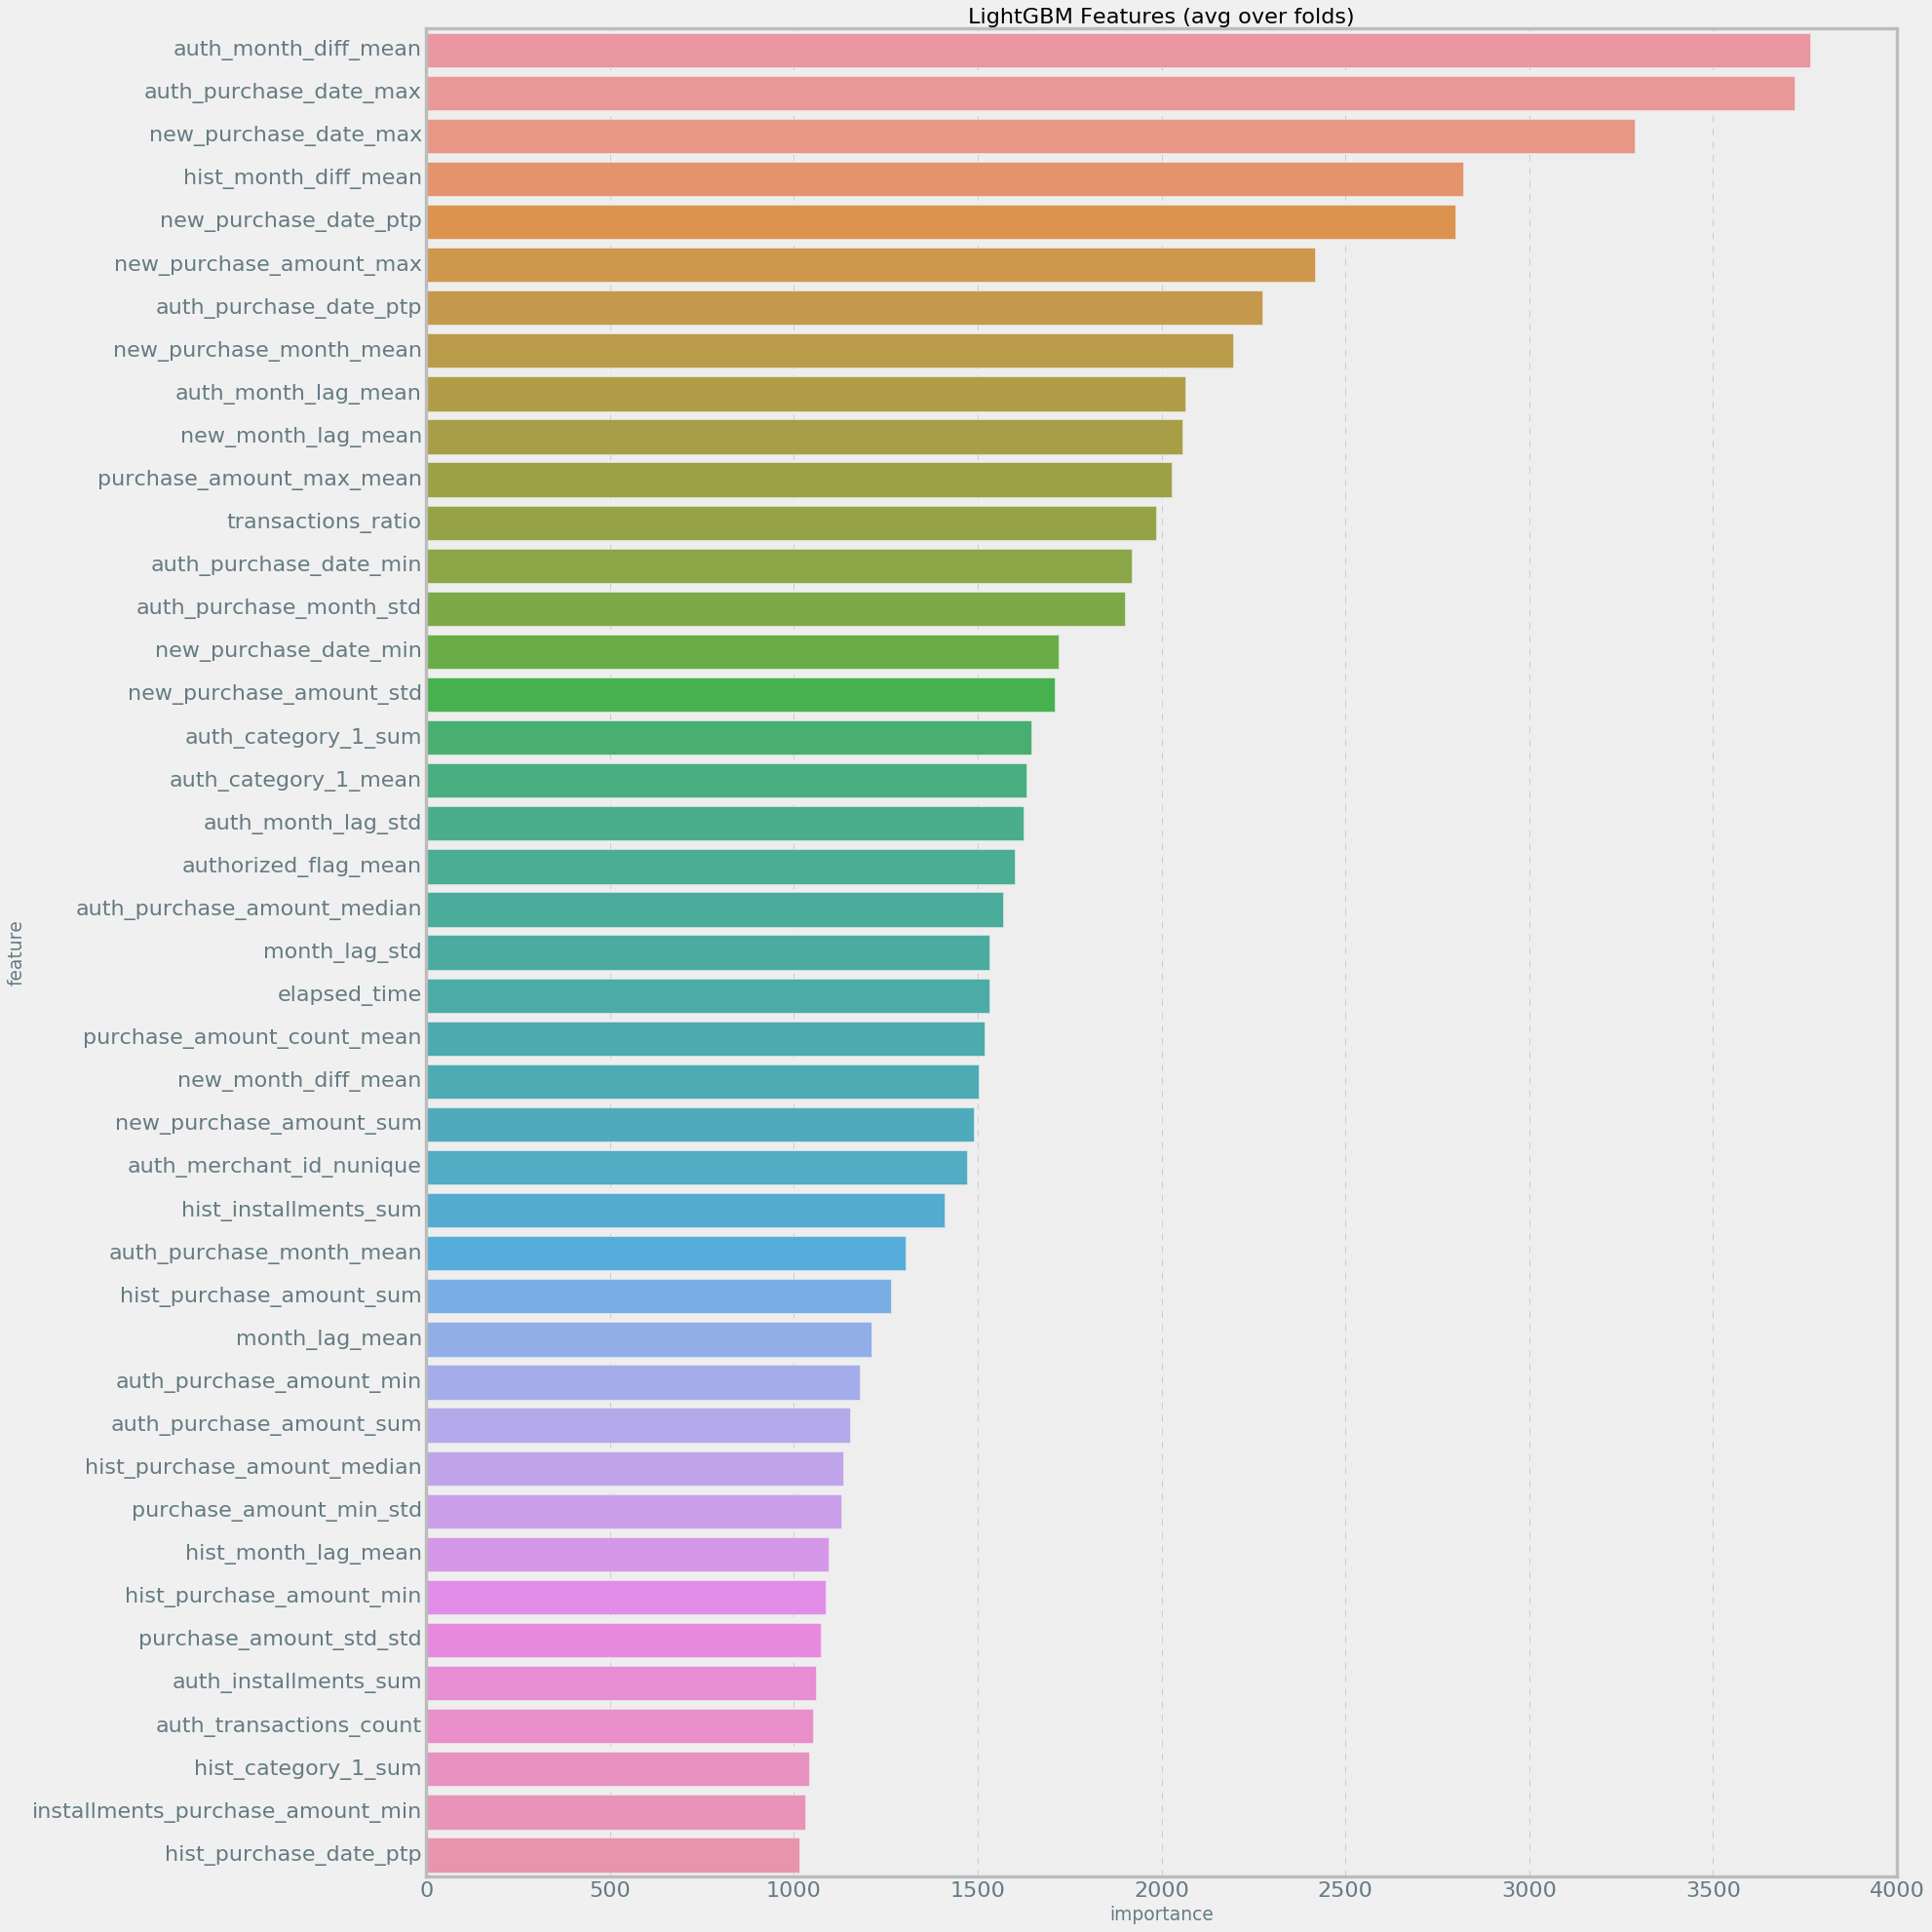

In [63]:
style.use('bmh')
plt.figure(figsize=(25,25))
sns.barplot(x="importance",
            y="feature",
            data=data)
plt.title('LightGBM Features (avg over folds)')
plt.xticks(size=20)
plt.yticks(size=20)
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [55]:
features_to_be_reused

['auth_month_diff_mean',
 'auth_purchase_date_max',
 'new_purchase_date_max',
 'hist_month_diff_mean',
 'new_purchase_date_ptp',
 'new_purchase_amount_max',
 'auth_purchase_date_ptp',
 'new_purchase_month_mean',
 'auth_month_lag_mean',
 'new_month_lag_mean',
 'purchase_amount_max_mean',
 'transactions_ratio',
 'auth_purchase_date_min',
 'auth_purchase_month_std',
 'new_purchase_date_min',
 'new_purchase_amount_std',
 'auth_category_1_sum',
 'auth_category_1_mean',
 'auth_month_lag_std',
 'authorized_flag_mean',
 'auth_purchase_amount_median',
 'month_lag_std',
 'elapsed_time',
 'purchase_amount_count_mean',
 'new_month_diff_mean',
 'new_purchase_amount_sum',
 'auth_merchant_id_nunique',
 'hist_installments_sum',
 'auth_purchase_month_mean',
 'hist_purchase_amount_sum',
 'month_lag_mean',
 'auth_purchase_amount_min',
 'auth_purchase_amount_sum',
 'hist_purchase_amount_median',
 'purchase_amount_min_std',
 'hist_month_lag_mean',
 'hist_purchase_amount_min',
 'purchase_amount_std_std',
 '

In [64]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submit.csv", index=False)